# Imported libraries

In [88]:
from bs4 import BeautifulSoup
from bs4 import Comment
import requests
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
%matplotlib inline



# Functions

In [2]:
def get_page_html(url):
    return requests.get(url)

In [3]:
def get_NHL_teams(NHL_teams_url):    
    parser = BeautifulSoup(NHL_teams_url.content, 'html.parser')
    names = list()
    teamurl = list()
    teampoints = list()
    table = parser.find_all('tbody')
    east = table[0].find_all('tr')
    #print(east)
    for team in east:
        test = team.find('th',{"data-stat":"team_name"})
        if(test != None):
            name = test.find('a')
            names.append(name.get_text())
            teamurl.append(name['href'])
            pts = team.find('td',{"data-stat":"points"})
            teampoints.append(int(pts.get_text()))
    west = table[1].find_all('tr')    
    for team in west:
        test = team.find('th',{"data-stat":"team_name"})
        if(test != None):
            name = test.find('a')
            names.append(name.get_text())
            teamurl.append(name['href'])
            pts = team.find('td',{"data-stat":"points"})
            teampoints.append(int(pts.get_text()))
    #print(pts)
    rank = [x for x in range(1,len(names)+1)]
    names = pd.Series(names,index=rank)
    teamurl = pd.Series(teamurl,index=rank)
    teampoints = pd.Series(teampoints,index=rank)
    teamranks = pd.DataFrame({'team':names,'url':teamurl,'points':teampoints})
    teamranks = teamranks.sort_values(by=['points'],ascending=False)
    return teamranks

In [4]:
def get_NBA_teams(csv):    
    source_file = csv
    data = pd.read_csv(source_file)# Your solution
    return data

In [33]:
def get_NHL_team_stats(teamurl):
    parser = BeautifulSoup(teamurl.content, 'html.parser')
    position = list()
    points = list()
    table = parser.find_all('tbody')
    players = table[3].find_all('tr')
    for player in players:
        #print(type(players))
        pos = player.find('td',{"data-stat":"pos"})
        if(pos != 'G'):
            position.append(pos.get_text())
            pts = player.find('td',{"data-stat":"points"})
            points.append(int(pts.get_text()))
    rank = [x for x in range(1,len(points)+1)]
    position = pd.Series(position,index=rank)
    points = pd.Series(points,index=rank)
    team_stats = pd.DataFrame({'position':position,'points':points})
    team_stats = team_stats.sort_values(by=['points'],ascending=False)
    return team_stats    
#stats = get_NHL_team_stats(test)
#stats.drop(stats[stats.points == 0].index, inplace=True)

In [34]:
def get_NBA_team_stats(teamurl):
    parser = BeautifulSoup(teamurl.content, 'html.parser')
    comments = parser.find_all(string=lambda text: isinstance(text, Comment))
    parser = BeautifulSoup(comments[23], 'html.parser')
    points = list()
    table = parser.find_all('tbody')
    players = table[0].find_all('tr')
    #print(players)
    for player in players:
        pts = player.find('td',{"data-stat":"pts_per_g"})
        points.append(float(pts.get_text()))
    rank = [x for x in range(1,len(points)+1)]
    points = pd.Series(points,index=rank)
    team_stats = pd.DataFrame({'avg points per game':points})
    team_stats = team_stats.sort_values(by=['avg points per game'],ascending=False)
    return team_stats

# Main

In [136]:
NHLteams2017url = 'https://www.hockey-reference.com/leagues/NHL_2017.html'
NHLteams2017url = get_page_html(NHLteams2017url)
NHLteams2017 = get_NHL_teams(NHLteams2017url)

NHLteams2018url = 'https://www.hockey-reference.com/leagues/NHL_2018.html'
NHLteams2018url = get_page_html(NHLteams2018url)
NHLteams2018 = get_NHL_teams(NHLteams2018url)


In [137]:
NBAteams2017url = 'nba_teams2017.csv'
NBAteams2017 = get_NBA_teams(NBAteams2017url)

NBAteams2018url = 'nba_teams2018.csv'
NBAteams2018 = get_NBA_teams(NBAteams2018url)

In [138]:
NHLteams2017Stats = list()
for NHLteam in NHLteams2017['url']:
    teamurl ='https://www.hockey-reference.com'+NHLteam
    teamurl = get_page_html(teamurl)
    NHLteams2017Stats.append(list(get_NHL_team_stats(teamurl)['points']))
    
NHLteams2018Stats = list()
for NHLteam in NHLteams2018['url']:
    teamurl ='https://www.hockey-reference.com'+NHLteam
    teamurl = get_page_html(teamurl)
    NHLteams2018Stats.append(list(get_NHL_team_stats(teamurl)['points']))
    

In [140]:
NBAteams2017Stats = list()
for NBAteam in NBAteams2017['url']:
    teamurl ='https://www.basketball-reference.com/teams/'+NBAteam+'/2017.html'
    teamurl = get_page_html(teamurl)
    NBAteams2017Stats.append(list(get_NBA_team_stats(teamurl)['avg points per game']))

NBAteams2018Stats = list()
for NBAteam in NBAteams2018['url']:
    teamurl ='https://www.basketball-reference.com/teams/'+NBAteam+'/2018.html'
    teamurl = get_page_html(teamurl)
    NBAteams2018Stats.append(list(get_NBA_team_stats(teamurl)['avg points per game']))
    

In [124]:
teams2017=list()
for name in list(NHLteams2017['team']):
    teams2017.append(name.strip())
scores = {name.strip(): [] for name in teams2017}
for team, spread in zip(teams2017, NHLteams2017Stats):
    scores[team] = spread
NHLdata2017 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in scores.items() ]))

teams2018=list()
for name in list(NHLteams2018['team']):
    teams2018.append(name.strip())
scores = {name.strip(): [] for name in teams2018}
for team, spread in zip(teams2018, NHLteams2018Stats):
    scores[team] = spread
NHLdata2018 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in scores.items() ]))

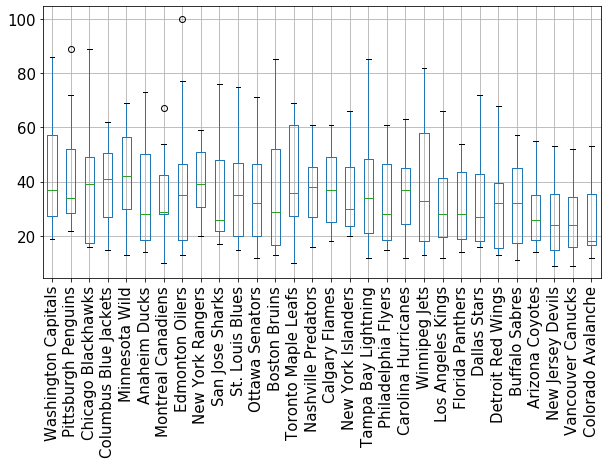

In [156]:
NHL2017boxplot = NHLdata2017.head(15).boxplot(figsize=(10,5),fontsize=15,rot=90)
# fig = NHL2017boxplot.get_figure()
# fig.savefig("NHL2017boxplot.png")
NHL2017boxplot


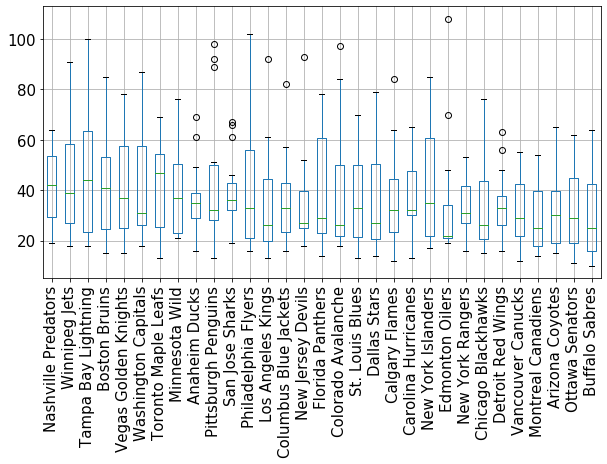

In [157]:
NHL2018boxplot = NHLdata2018.head(15).boxplot(figsize=(10,5),fontsize=15,rot=90)
# fig = NHL2018boxplot.get_figure()
# fig.savefig("NHL2018boxplot.png")
NHL2018boxplot

In [146]:
teams2017=list()
for name in list(NBAteams2017['Team']):
    teams2017.append(name.strip())
scores = {name.strip(): [] for name in teams2017}
for team, spread in zip(NBAteams, NBAteamsStats):
    scores[team] = spread
NBAdata2017 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in scores.items() ]))

teams2018=list()
for name in list(NBAteams2018['Team']):
    teams2018.append(name.strip())
scores = {name.strip(): [] for name in teams2018}
for team, spread in zip(NBAteams, NBAteamsStats):
    scores[team] = spread
NBAdata2018 = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in scores.items() ]))

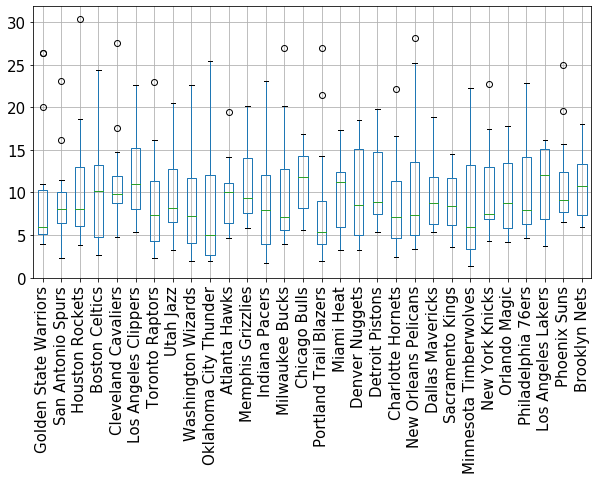

In [158]:
NBAboxplot2017 = NBAdata2017.head(15).boxplot(figsize=(10,5),fontsize=15,rot=90)
# fig = NBAboxplot2017.get_figure()
# fig.savefig("NBAboxplot2017.png")
NBAboxplot2017

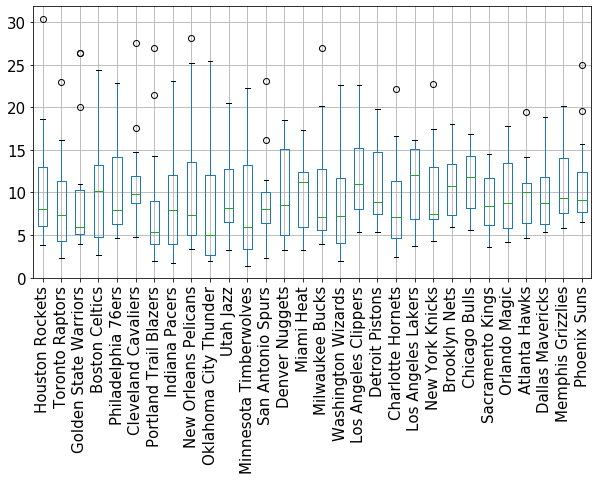

In [159]:
NBAboxplot2018 = NBAdata2018.head(15).boxplot(figsize=(10,5),fontsize=15,rot=90)
# fig = NBAboxplot2018.get_figure()
# fig.savefig("NBAboxplot2018.png")
NBAboxplot2018

# Part 2
## 1 Versus 1 Predictor

In [1]:
# Web-scraping

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

page_url = 'https://www.hockey-reference.com/leagues/NHL_2018_games.html'

def get_page_html(url):
    res = requests.get(url)
    return res.text

matches_html = get_page_html(page_url)
print(matches_html)


<!DOCTYPE html>
<html data-version="klecko-" data-root="/home/hr/build" itemscope itemtype="https://schema.org/WebSite" lang="en" class="no-js" >
<head>
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />
    <link rel="dns-prefetch" href="https://d2p3bygnnzw9w3.cloudfront.net/req/201911212" />

<!-- no:cookie fast load the css.           -->

<script>function gup(n) {n = n.replace(/[\[]/, '\\[').replace(/[\]]/, '\\]'); var r = new RegExp('[\\?&]'+n+'=([^&#]*)'); var re = r.exec(location.search);   return re === null?'':decodeURIComponent(re[1].replace(/\+/g,' '));}; document.srdev = gup('srdev')</script>
<link rel="preconnect" href="https://d2p3bygnnzw9w3.cloudfront.net" crossorigin>
<link rel="preconnect" href="https://d9kjk42l7bfqz.cloudfront.net" crossorigin>
 <style>html,body{margin:0;padding:0;font:14px/1.25 "Helvetica Neue",helvetica,arial,sans-serif;

In [2]:
# Scraping and pre-processing

# Used to give each team a number, so can run ML on match data
team_index = {'Anaheim Ducks': 0, 'Boston Bruins': 1, 'Buffalo Sabres': 2, 'Calgary Flames': 3,
             'Carolina Hurricanes': 4, 'Chicago Blackhawks': 5, 'Colorado Avalanche': 6,
             'Columbus Blue Jackets': 7, 'Dallas Stars': 8, 'Detroit Red Wings': 9, 'Edmonton Oilers': 10,
             'Florida Panthers': 11, 'Los Angeles Kings': 12, 'Minnesota Wild': 13, 'Montreal Canadiens': 14,
             'Nashville Predators': 15, 'New Jersey Devils': 16, 'New York Islanders': 17,
             'New York Rangers': 18, 'Ottawa Senators': 19, 'Philadelphia Flyers': 20, 'Arizona Coyotes': 21,
             'Pittsburgh Penguins': 22, 'St. Louis Blues': 23, 'San Jose Sharks': 24, 'Tampa Bay Lightning': 25,
             'Toronto Maple Leafs': 26, 'Vancouver Canucks': 27, 'Vegas Golden Knights': 28, 
             'Washington Capitals': 29, 'Winnipeg Jets': 30}

# Scrape match data
def get_matches(matches_url):
    parser = BeautifulSoup(matches_url, 'html.parser')
    table = parser.find_all('td')
    data = {'Visitor': [p.get_text() for p in table if p['data-stat']=='visitor_team_name'],
            'VG': [p.get_text() for p in table if p['data-stat']=='visitor_goals'],
            'Home' : [p.get_text() for p in table if p['data-stat']=='home_team_name'],
            'HG': [p.get_text() for p in table if p['data-stat']=='home_goals']}
    dataframe = pd.DataFrame(data)
    return dataframe

# Convert team names to numbers, based on index above
def convert_data(dataframe):
    dataframe = dataframe.replace({'Visitor': team_index})
    dataframe = dataframe.replace({'Home': team_index})
    return dataframe

# Calculate which team won based on goals scored, returns True/False
def calculate_wins(dataframe):
    win = dataframe.VG > dataframe.HG
    return win

def update_streak(place, win, streak):
    if (place == 'home' and win == True) or (place == 'away' and win == False):
        if streak < 0:
            new_streak = streak - 1
        else:
            new_streak = -1
    elif (place == 'away' and win == True) or (place == 'home' and win == False):
        if streak > 0:
            new_streak = streak + 1
        else:
            new_streak = 1
    return new_streak

def calculate_streak(team):
    streak = 0 # Initially, no team has won or lost
    for index, row in games_2018.iterrows():  
        if row['Visitor'] == team or row['Home'] == team:
            if row['Visitor'] == team:
                games_2018.at[index, 'Visitor Streak'] = streak
                streak = update_streak('away', row['Win'], streak)
            elif row['Home'] == team:
                games_2018.at[index, 'Home Streak'] = streak
                streak = update_streak('home', row['Win'], streak)
    return None

games_2018 = get_matches(matches_html)
games_2018 = convert_data(games_2018)

games_2018['Win'] = calculate_wins(games_2018)
games_2018 = games_2018.drop(columns=['VG', 'HG']) # Remove goal amounts

games_2018['Visitor Streak'] = np.nan
games_2018['Home Streak'] = np.nan
for team in range(0, 31):
    calculate_streak(team)

# Shift columns
games_2018 = games_2018[['Visitor', 'Home', 'Visitor Streak', 'Home Streak', 'Win']]

games_2018

,Visitor,Home,Visitor Streak,Home Streak,Win
0,3,10,0.0,0.0,False
1,23,22,0.0,0.0,True
2,20,24,0.0,0.0,True
3,26,30,0.0,0.0,True
4,21,0,0.0,0.0,False
5,15,1,0.0,0.0,False
6,14,2,0.0,0.0,True
7,22,5,-1.0,0.0,False
8,13,9,0.0,0.0,False
9,20,12,1.0,0.0,False


Decision Tree Score:  0.5162241887905604
KNN 10 Score:  0.5575221238938053


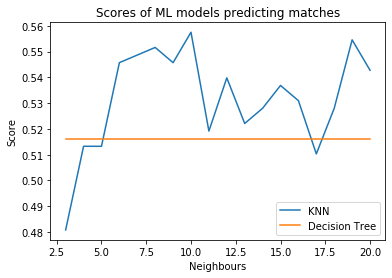

In [5]:
# Prediction

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

features = games_2018.iloc[:, :-1]
labels = games_2018.iloc[:, -1]

x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=50)

x_plot = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
knn_scores = []
dt_scores = []

dt = DecisionTreeClassifier(random_state=50).fit(x_train, y_train)
print('Decision Tree Score: ', dt.score(x_test, y_test))

for x in x_plot:
    k_neigh = KNeighborsClassifier(n_neighbors=x).fit(x_train, y_train)
    knn_scores.append(k_neigh.score(x_test, y_test))
    dt_scores.append(dt.score(x_test, y_test))

k_neigh = KNeighborsClassifier(n_neighbors=10).fit(x_train, y_train)
print('KNN 10 Score: ', k_neigh.score(x_test, y_test))

# Visualization

df = pd.DataFrame(knn_scores)
fig = plt.figure()
ax = plt.subplot()
ax.plot(x_plot, df, label='KNN')
ax.plot(x_plot, dt_scores, label='Decision Tree')
ax.set_ylabel('Score')
ax.set_xlabel('Neighbours')
ax.set_title('Scores of ML models predicting matches')
ax.legend()

plt.show()

KNN 10 - WIN % OF AWAY TEAMS
Team 0:  0.47
Team 1:  0.48
Team 2:  0.48
Team 3:  0.46
Team 4:  0.41
Team 5:  0.42
Team 6:  0.46
Team 7:  0.44
Team 8:  0.46
Team 9:  0.44
Team 10:  0.4
Team 11:  0.43
Team 12:  0.42
Team 13:  0.46
Team 14:  0.51
Team 15:  0.53
Team 16:  0.53
Team 17:  0.47
Team 18:  0.38
Team 19:  0.35
Team 20:  0.34
Team 21:  0.38
Team 22:  0.43
Team 23:  0.5
Team 24:  0.52
Team 25:  0.5
Team 26:  0.52
Team 27:  0.5
Team 28:  0.52
Team 29:  0.54
Team 30:  0.55

Average visitor probability:  0.461

Average home probability:  0.539


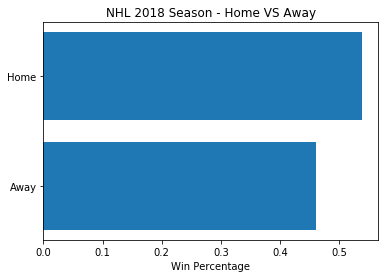

In [9]:
# Analysis

def calculate_probabilities(model):
    visitor_probs = []
    home_probs = []
    for visitor in range(0, 31):
        visitors = []
        for home in range(0, 31):
            if home == visitor: # Teams can't play themselves
                continue
            visitor_probs.append(model.predict_proba([[visitor, home, 0, 0]])[0][1])
            home_probs.append(model.predict_proba([[visitor, home, 0, 0]])[0][0])
            visitors.append(model.predict_proba([[visitor, home, 0, 0]])[0][1])
        avg_visitor = round(sum(visitors) / len(visitors), 2)
        print('Team ' + str(visitor) + ': ', avg_visitor)
    avg_visitor_probs = round(sum(visitor_probs) / len(visitor_probs), 3)
    print('\nAverage visitor probability: ', avg_visitor_probs)
    avg_home_probs = round(sum(home_probs) / len(home_probs), 3)
    print('\nAverage home probability: ', avg_home_probs)
    return [avg_home_probs, avg_visitor_probs]


print('KNN 10 - WIN % OF AWAY TEAMS')
k_neigh = KNeighborsClassifier(n_neighbors=10).fit(x_train, y_train)

home_away = calculate_probabilities(k_neigh)

fig, ax = plt.subplots()

y_pos = ['Home', 'Away']

ax.barh(y_pos, home_away, align='center')
ax.set_yticks(y_pos)
#ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Win Percentage')
ax.set_title('NHL 2018 Season - Home VS Away')

plt.show()